In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

In [0]:
path="/content/drive/My Drive/Colab Notebooks/dataset"

In [0]:
os.listdir(os.path.join(os.getcwd(),"/content/drive/My Drive/Colab Notebooks/dataset"))

['.DS_Store', 'trash', 'plastic', 'paper', 'metal', 'glass', 'cardboard']

In [0]:
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    remain = list(set(full_set)-set(train))

    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    


def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [0]:
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']


for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('/content/drive/My Drive/Colab Notebooks/dataset',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('/content/drive/My Drive/Colab Notebooks/dataset','test')):
    os.makedirs(os.path.join('/content/drive/My Drive/Colab Notebooks/dataset','test'))
            

for waste_type in waste_types:
    source_folder = os.path.join('/content/drive/My Drive/Colab Notebooks/dataset',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "/content/drive/My Drive/Colab Notebooks/dataset/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "/content/drive/My Drive/Colab Notebooks/dataset/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"/content/drive/My Drive/Colab Notebooks/dataset/test")

In [0]:
path="/content/drive/My Drive/Colab Notebooks/dataset"


In [0]:
transform = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=transform,bs=16)

In [0]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: /content/drive/My Drive/Colab Notebooks/dataset;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: /content/drive/My Drive/Colab Notebooks/dataset;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/Colab Notebooks/dataset

In [0]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


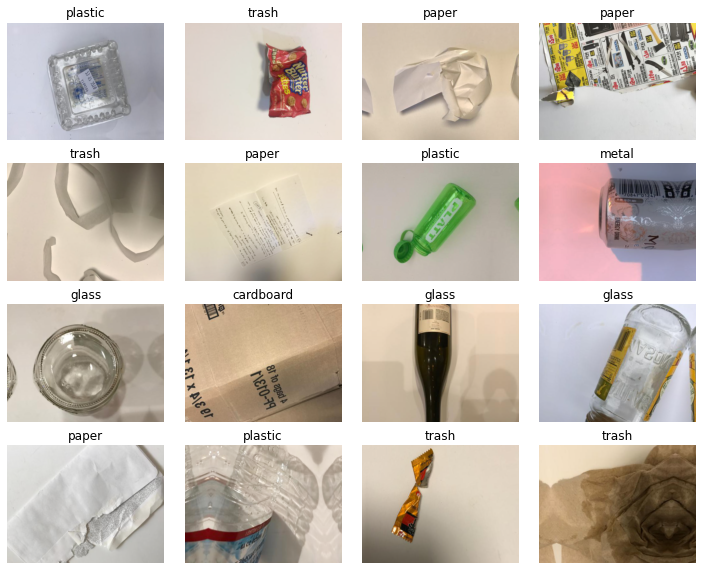

In [0]:

data.show_batch(rows=4,figsize=(10,8))

In [0]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
model = learn.model  
# model = model.model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


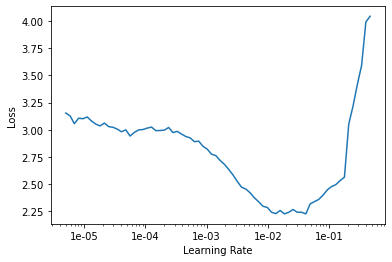

In [0]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(20,max_lr=5.13e-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.692883,0.662829,0.242857,02:29
1,1.035562,0.567256,0.184127,00:33
2,0.813200,0.528336,0.165079,00:34
3,0.845825,0.552022,0.193651,00:34
4,0.822940,0.583919,0.184127,00:33
5,0.817598,0.757632,0.226984,00:34
6,0.786953,0.493494,0.158730,00:33
7,0.698843,0.662466,0.196825,00:33
8,0.678048,0.381336,0.128571,00:33
9,0.694487,0.478425,0.166667,00:34


In [0]:
pred = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
pred

[tensor([[4.6000e-06, 4.7206e-05, 4.4205e-03, 1.1074e-04, 3.5038e-03, 9.9191e-01],
         [1.9326e-03, 5.6195e-03, 7.0839e-03, 1.7344e-02, 2.6957e-01, 6.9845e-01],
         [2.2175e-04, 9.3652e-05, 6.4871e-04, 1.1159e-02, 2.2776e-02, 9.6510e-01],
         ...,
         [9.6668e-01, 7.7410e-08, 5.3476e-06, 3.3307e-02, 4.4675e-08, 2.6596e-06],
         [9.9970e-01, 1.3569e-05, 1.3148e-05, 8.8651e-05, 4.9795e-05, 1.3073e-04],
         [9.9231e-01, 1.7510e-10, 6.8145e-09, 7.6888e-03, 2.5133e-08, 1.1878e-06]]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,


In [0]:
print(pred[0].shape)
pred[0]

torch.Size([635, 6])


tensor([[4.6000e-06, 4.7206e-05, 4.4205e-03, 1.1074e-04, 3.5038e-03, 9.9191e-01],
        [1.9326e-03, 5.6195e-03, 7.0839e-03, 1.7344e-02, 2.6957e-01, 6.9845e-01],
        [2.2175e-04, 9.3652e-05, 6.4871e-04, 1.1159e-02, 2.2776e-02, 9.6510e-01],
        ...,
        [9.6668e-01, 7.7410e-08, 5.3476e-06, 3.3307e-02, 4.4675e-08, 2.6596e-06],
        [9.9970e-01, 1.3569e-05, 1.3148e-05, 8.8651e-05, 4.9795e-05, 1.3073e-04],
        [9.9231e-01, 1.7510e-10, 6.8145e-09, 7.6888e-03, 2.5133e-08, 1.1878e-06]])

In [0]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [0]:
max_idxs = np.asarray(np.argmax(pred[0],axis=1))

In [0]:

predictions = []
for max_idx in max_idxs:
    predictions.append(data.classes[max_idx])

In [0]:
predictions

['trash',
 'trash',
 'trash',
 'paper',
 'trash',
 'trash',
 'trash',
 'trash',
 'trash',
 'trash',
 'plastic',
 'trash',
 'trash',
 'trash',
 'trash',
 'trash',
 'trash',
 'trash',
 'trash',
 'trash',
 'trash',
 'trash',
 'trash',
 'plastic',
 'trash',
 'trash',
 'trash',
 'trash',
 'trash',
 'paper',
 'paper',
 'trash',
 'trash',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'paper',
 'trash',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'plastic'

In [0]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [0]:

cm = confusion_matrix(y,predictions)
print(cm)


[[ 94   1   3   3   0   0]
 [  0 114   8   0   4   0]
 [  0   4  95   2   1   1]
 [  0   0   0 145   2   2]
 [  0   3   0   0 118   0]
 [  0   0   0   4   2  29]]


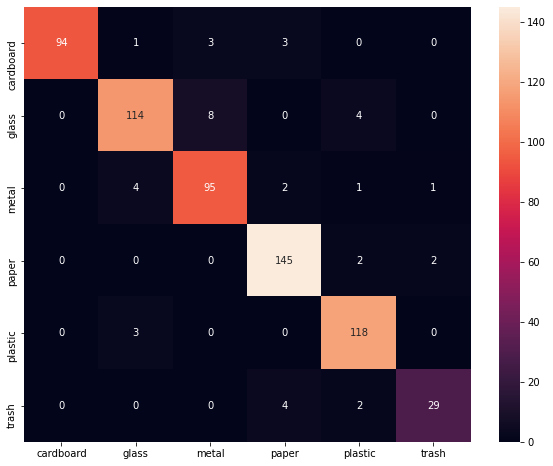

In [0]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d")
plt.savefig(fname="/content/drive/My Drive/Colab Notebooks/dataset/heatmap.jpg")

In [0]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

accuracy = correct/sum(sum(cm))
accuracy

0.937007874015748

In [0]:
import pickle

In [0]:
import dill

In [0]:
# with open('model_pickle','wb') as dill_file:
#   dill.dump(learn,dill_file)

In [0]:
# with open('model_pickle','rb') as dill_file:
#   mp=dill.load(dill_file)

In [0]:
saved_model = pickle.dumps(learn.model) 


In [0]:
classifier_from_pickle = pickle.loads(saved_model) 

In [0]:
classifier_from_pickle

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [0]:
# pred = classifier_from_pickle.get_preds(ds_type=DatasetType.Test)